# Исследование объявлений о продаже квартир

Имеются данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Цель исследования — установить параметры определения стоимости объектов недвижимости, которые позволят построить автоматизированную систему отслеживания аномалий и мошеннической деятельности.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('real_estate_data.csv', sep='\t')
pd.set_option('display.max_columns', None)
display(data.head())

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
# изучение общей информации по таблице

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Всего в таблице 23699 строк, 22 столбца, примерно в половине столбцов имеются пропущенные значения. В процессе предобработки данных изучим их детально и заполним пропуски в необходимых для анализа столбцах таблицы

Согласно описанию, в таблице представлена следующая информация по столбцам:

* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах (м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении

**Вывод**

В исходном датасете данные о квартирах на продажу из сервиса Яндекс Недвижимость.

Для ответа на вопросы исследования необходимо провести предобработку данных, а именно:

1. Изучить пропуски и обработать отсутствующие значения
2. Удалить дубликаты
2. Изменить типы данных в столбцах, где они не соответствуют своему наполнению

## Предобработка данных

Начнем обрабатывать данные с переименования столбцов в датасете. В датасете имеются названия, не соответствующие "змеиному" регистру и имеющие в названии лишние символы. Переименуем столбцы для удобства

In [3]:
# переименование столбцов датасета

data.rename(columns=
            {'cityCenters_nearest': 'city_centers_nearest', 
             'parks_around3000': 'parks_around_3_km', 
             'ponds_around3000': 'ponds_around_3_km'}, 
            inplace=True)
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'city_centers_nearest',
       'parks_around_3_km', 'parks_nearest', 'ponds_around_3_km',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

Посчитаем пропуски в данных и дадим предварительную оценку

In [4]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_3_km        5518
parks_nearest           15620
ponds_around_3_km        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Значительное количество пропусков в столбцах parks_nearest и ponds_nearest. Можно предположить, что это данные вписанные пользователями, пропуски данных, скорее всего, означают либо отсутствие положительного ответа по характеристикам, либо отсутствие информации у пользователей по поводу близлижащих водоемов и парков. 

Наибольшее количество пропусков в столбце is_apartment, так как данная характеристика говорит о типе недвижимости и заполняется пользователями, логично будет заполнить пропуски значением False, так как размещающий объявление человек должен знать, имеет ли его квартира возможность прописки в ней или нет. Если данные не указаны - будем предполагать, что это жилая недвижимость, не относящаяся к категории апартаментов.

Данные о количестве балконов рассмотрим в зависимости от этажа, если пропуски соответствуют квартирам на первом этаже, тогда будет логично предположить, что информация не указана, так как балконы отсутствуют. В ином случае, если гипотеза не подтвердится, заполним пропуски значением ноль, так как вероятно отсутствие вписанной информации о количестве балконов означает их отсутствие.

Пропуски в столбце city_centers_nearest и airports_nearest могли возникнуть в связи с некорректной информацией об объектах недвижимости, по которым сервис пытался автоматически получить картографические данные об объекте. Пропуски предположительно можно заполнить в зависимости от территориального расположения недвижимости, изучив значения по locality_name. Тоже самое с значениями airports_nearest.

Столбцы с количественными характеристиками, такие как ceiling_height, living_area, kitchen_area, floors_total будем заполнять в зависимости от медианных и средних значений в связке с другими факторами недвижимости. Пропуски в данных столбцах - это невписанная информация в объявления от самих пользователей, так как данные не заполняются сервисом автоматически. Некоторые не знают квадратуру своих квартир и в целью быстрее опубликовать объявление не стремятся заполнить все характеристики, или могут писать, что на дополнительные вопросы ответят в сообщениях.

Пропуски в столбце days_exposition рассмотрим подробнее, предварительно предположим, что отсутствует информация об объявлениях, еще не снятых с публикации.

Останутся незначительные по количеству пропуски в столбцах floors_total и locality_name, также изучим их и найдем способы заполнения. В ином случае от указанных строк можно будет отказаться, так как их влияние незначительно относительно общей выборки.

In [5]:
# просмотр значений в столбце is_apartment

data['is_apartment'].unique()

array([nan, False, True], dtype=object)

In [6]:
# заполнение пропусков в столбце is_apartment

print('Пропусков до:', data['is_apartment'].isna().sum())
data['is_apartment'] = data['is_apartment'].fillna(False)
print('Пропусков после:', data['is_apartment'].isna().sum())

Пропусков до: 20924
Пропусков после: 0


Пропуски в is_apartment заполнены, перейдем к характеристикам о количестве балконов

In [7]:
data['balcony'].unique()

array([nan,  2.,  0.,  1.,  5.,  4.,  3.])

In [8]:
data[(data['floor'] == 1) & (data['balcony'] != 0.0)].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3_km,parks_nearest,ponds_around_3_km,ponds_nearest,days_exposition
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,False,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
16,11,6700000.0,82.0,2017-11-23T00:00:00,3,3.05,5.0,55.6,1,False,False,False,9.0,NaN,Санкт-Петербург,22108.0,10698.0,3.0,420.0,0.0,NaN,397.0
28,8,4170000.0,44.0,2017-12-13T00:00:00,1,2.90,6.0,20.8,1,False,False,False,11.7,1.0,Пушкин,18557.0,30710.0,0.0,NaN,1.0,118.0,74.0
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.50,5.0,NaN,1,False,False,False,NaN,NaN,поселок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0
68,11,4150000.0,74.0,2017-08-04T00:00:00,3,2.80,5.0,44.0,1,False,False,False,8.0,2.0,деревня Фёдоровское,NaN,NaN,NaN,NaN,NaN,NaN,234.0


Мы видим, что в датафрейме есть недвижимость на первом этаже с количеством балконов от 1 и более, значит гипотеза об отсутствии балконов на 1 этаже не подтвердилась. Заполним пропуски значением "0", так как при отсутствии информации от пользователя о количестве балконов, вероятнее всего их нет, ведь для расчета их количество не требуются дополнительные навыки или недоступная для простого человека информация.

In [9]:
# заполнение пропусков в столбце "количество балконов"

print('Пропусков до:', data['balcony'].isna().sum())
data['balcony'].fillna(0, inplace=True)
data['balcony'] = data['balcony'].astype(int)
print('Пропусков после:', data['balcony'].isna().sum())

Пропусков до: 11519
Пропусков после: 0


Рассмотрим уникальные значения и их количество в столбце **locality_name**:

In [10]:
display(data['locality_name'].unique())
print('Количество уникальных значений locality name:', len(data['locality_name'].unique()))

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Количество уникальных значений locality name: 365


По списку значений мы видим не нужные для анализа словосочетания в названии населенных пунктов, создающие дубликаты для locality_name. Удалим из названий "поселок городского типа", "посёлок", "посёлок городского типа", "садовое товарищество", "деревня", "село", "городской посёлок".

In [11]:
bad_words = ['поселок', 'посёлок', 'деревня', 'коттеджный', 'городского', 'типа', 'станции', 'городской', 'при', 'железнодорожной', 'село', 'садовое', 'товарищество']

for word in bad_words:
    data['locality_name'] = data['locality_name'].str.replace(word,'')
data['locality_name'] = data['locality_name'].str.strip()
print('Количество уникальных значений населенных пунктов после обработки дубликатов:', len(data['locality_name'].unique()))

Количество уникальных значений населенных пунктов после обработки дубликатов: 306


Из 365 значений с дубликатами, осталось 306. Мы переименовали значения в строках датафрейма, убрав приписки о типе населенного пункта, оставив только их названия.

Даже с учетом удаления дубликатов, уникальных значений населенных пунктов большая выборка. Пропущенных значений по столбцу **locality_name** всего 49. Так как мы имеем только 2 переменные для поиска населенного пункта (удаленность от центра, удаленность от ближайшего аэропорта), то мы не сможем со 100% уверенностью утверждать о названии населенного пункта в пропущенных строках, даже в случае полного совпадения удаленности от центра и от аэропорта по каким-либо другим строкам с заполненным значением locality_name.


Помимо столбца locality_name, незначительное количество пропусков в столбце **floors_total**.
Удалим строки с пропусками **locality_name** и **floors_total**, так как суммарное количество пропусков по обоим столбцам незначительно и не ухудшит качество данных.

In [12]:
# очистка датасета от строк с пропусками в locality_name

data = data.dropna(subset=['locality_name', 'floors_total'])

Логично предположить, что отсутствие значений в **days_exposition** связано с тем, что объявления еще висят на сайте. Посмотрим распределение количества объявлений, где отсутствуют значения в days_exposition по датам публикации **first_day_exposition**.

In [13]:
# переведём столбец first_day_exposition к формату даты
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

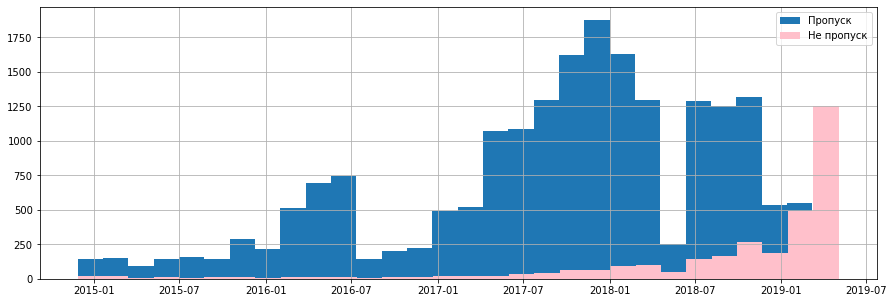

In [14]:
plt.figure(figsize=(15,5))
data[data['days_exposition'].isna() == False]['first_day_exposition'].hist(label='Пропуск', bins=30)
data[data['days_exposition'].notna() == False]['first_day_exposition'].hist(label='Не пропуск', color='pink',bins=30)

plt.legend()
plt.show()

По гистограмме видно, что количество объявлений с пропусками в столбце days_exposition значительно увеличивается с течением времени. Гипотеза о том, что отсутствующие значения означают, что объявление, на момент выгрузки данных, еще не было удалено с сайта подтверждается.
Поэтому, указанные пропуски заполнять не будем, так как один из вопросов исследования: изучить время продажи квартир, какие продаются быстрее, какие дольше. Если мы заполним столбец данными, то исказим результаты, так как большинство квартир с пропусками в количестве дней до снятия объявления еще не были сняты.

Пропуски в столбце **ceiling_height** заполним медианными значениями, с группировкой по этажности домов, хотя в среднем стандартное значение потолков 2,6-2,7м, могут быть отличия в зависимости от года постройки и эпохи строительства.

In [15]:
# заполнение пропусков ceiling_height с группировкой по этажности домов

print('Пропуски до:', data['ceiling_height'].isna().sum())
data['ceiling_height'] = data.groupby('floors_total')['ceiling_height'].transform(lambda x : x.fillna(x.median()))     
print('Пропуски после:', data['ceiling_height'].isna().sum())

Пропуски до: 9084
Пропуски после: 1


In [16]:
data[data['ceiling_height'].isna()]['floors_total']

11575    33.0
Name: floors_total, dtype: float64

Остался дом 33 этажа без медианного значения по своей группе этажности. Заполним данный пропуск медианным значением по всему столбцу

In [17]:
print('Пропуски до:', data['ceiling_height'].isna().sum())
print('Медианное значение по всему столбцу:', data['ceiling_height'].median())
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
print('Пропуски после:', data['ceiling_height'].isna().sum())

Пропуски до: 1
Медианное значение по всему столбцу: 2.65
Пропуски после: 0


Обработаем пропуски в столбцах **kitchen_area** и **living_area**. Для начала посмотрим на значения столбцов с площадями помещений с группировкой по количеству комнат в квартире.

In [18]:
data.pivot_table(index='rooms', values=['living_area', 'total_area', 'kitchen_area'], aggfunc= ['mean', 'median'])

mean                               median                       
      kitchen_area living_area  total_area kitchen_area living_area total_area
rooms                                                                         
0              NaN   18.865246   29.321701          NaN      18.000     26.075
1         9.544076   17.899507   37.636569         9.00      17.600     36.600
2         9.970915   31.731865   55.821274         8.70      30.500     53.000
3        11.292920   47.374108   77.706740         9.50      45.000     72.800
4        13.672140   66.994806  107.521459        11.00      63.650     99.300
5        18.367649  100.009247  161.517200        15.10      91.785    146.000
6        21.098229  131.799796  202.571635        19.75     124.400    186.150
7        21.998077  163.564151  265.325424        20.00     145.000    214.000
8        24.866667  168.683333  259.233333        25.00     161.000    235.700
9        25.071429  190.257143  305.975000        14.30     179.200    300.950
10       22.866667  165.566667  259.566667        19.80     161.400    272.600
11       12.600000  133.900000  188.900000        12.60     133.900    188.900
12      112.000000  409.700000  900.000000       112.00     409.700    900.000
14       21.250000  195.150000  304.200000        21.25     195.150    304.200
15      100.000000  409.000000  590.000000       100.00     409.000    590.000
16       13.000000  180.000000  270.000000        13.00     180.000    270.000
19       27.600000  264.500000  374.600000        27.60     264.500    374.600

По средним и медианам мы видим, что заполнить пропуски в kitchen_area или living_area, вычитая из общей площадки total_area одну из известных мы не сможем, так как в общую площадь также входит квадратура коридоров, балконов, лоджий, санузлов.

В квартирах, где пользователи указали 0 комнат, везде отсутствуют значения для kitchen_area, можно предположить, что с цифрой 0 пользователи обозначали однокомнатные квартиры-студии, где кухня соединена с жилым пространством. Проверим данную гипотезу

In [19]:
print('Количество студий всего:', data[data['studio'] == True]['studio'].count())
print('Количество квартир (студий и не студий) с 0 комнат всего:', data[data['rooms'] == 0].shape[0])
print('Количество студий с пропущенными значениями площади кухонь всего:',
     data.loc[(data['kitchen_area'].isna()) & (data['studio'] == True)].shape[0])
print('Количество студий с пропущенными значениями площади кухонь, где указано 0 комнат:', 
      data.loc[(data['kitchen_area'].isna()) & (data['studio'] == True) & (data['rooms'] == 0)].shape[0])
print('Количество студий с 0 комнат всего:',
     data.loc[(data['studio'] == True) & (data['rooms'] == 0)].shape[0])
print('Количество студий с 1 комнатой с пропущенными значениями площади кухонь:',
     data.loc[(data['rooms'] == 1) & (data['studio'] == True) & (data['kitchen_area'].isna())].shape[0])
print('Количество квартир не студий с 0 комнатами:', data.loc[(data['rooms'] == 0) & (data['studio'] == False)].shape[0])

Количество студий всего: 146
Количество квартир (студий и не студий) с 0 комнат всего: 194
Количество студий с пропущенными значениями площади кухонь всего: 146
Количество студий с пропущенными значениями площади кухонь, где указано 0 комнат: 135
Количество студий с 0 комнат всего: 135
Количество студий с 1 комнатой с пропущенными значениями площади кухонь: 11
Количество квартир не студий с 0 комнатами: 59


Всего студий в датасете 146, во всех пропущены значения с площадью кухонь. Значит гипотеза подтвердилась.

Также, мы видим, что количество студий с 0 комнатами 135, и из них строк, где отсутствует площадь кухонь, ровно столько же.

Всего студий с пропущенными значениями площади кухонь 146, из них 11 с одной комнатой.

Для того, чтобы привести данные к общему виду, изменим строки с количеством комнат 0 на 1, так как всю квартиру-студию можно считать за целую комнату, а квартиры, где пользователи указали 0 комнат, скорее всего ошибка или опечатка при вводе данных.

In [20]:
# изменение значений 0 комнат на 1 комната в столбце rooms

data.loc[data['rooms'] == 0, 'rooms'] = 1

Теперь заполним пропуски в столбцах **kitchen_area** и **living_area** медианными значениями группировкой по количеству комнат в квартире.

In [21]:
# заполнение пропусков в kitchen_area

print('Пропуски до:', data['kitchen_area'].isna().sum())
for rooms in data['rooms'].unique():
    median = data.loc[data['rooms'] == rooms, 'kitchen_area'].median()
    print('Кол-во комнат:', rooms, 'медианный размер кухни:', median)
    data.loc[(data['kitchen_area'].isna()) & (data['rooms'] == rooms), 'kitchen_area'] = median
print('Пропуски после:', data['kitchen_area'].isna().sum())

Пропуски до: 2222
Кол-во комнат: 3 медианный размер кухни: 9.5
Кол-во комнат: 1 медианный размер кухни: 9.0
Кол-во комнат: 2 медианный размер кухни: 8.7
Кол-во комнат: 4 медианный размер кухни: 11.0
Кол-во комнат: 5 медианный размер кухни: 15.1
Кол-во комнат: 6 медианный размер кухни: 19.75
Кол-во комнат: 7 медианный размер кухни: 20.0
Кол-во комнат: 11 медианный размер кухни: 12.600000000000001
Кол-во комнат: 8 медианный размер кухни: 25.0
Кол-во комнат: 14 медианный размер кухни: 21.25
Кол-во комнат: 10 медианный размер кухни: 19.8
Кол-во комнат: 15 медианный размер кухни: 100.0
Кол-во комнат: 9 медианный размер кухни: 14.3
Кол-во комнат: 19 медианный размер кухни: 27.6
Кол-во комнат: 16 медианный размер кухни: 13.0
Кол-во комнат: 12 медианный размер кухни: 112.0
Пропуски после: 0


In [22]:
# заполнение пропусков в living_area

print('Пропуски до:', data['living_area'].isna().sum())
for rooms in data['rooms'].unique():
    median = data.loc[data['rooms'] == rooms, 'living_area'].median()
    print('Кол-во комнат:', rooms, 'медианная жилая площадь:', median)
    data.loc[(data['living_area'].isna()) & (data['rooms'] == rooms), 'living_area'] = median
print('Пропуски после:', data['living_area'].isna().sum())

Пропуски до: 1865
Кол-во комнат: 3 медианная жилая площадь: 45.0
Кол-во комнат: 1 медианная жилая площадь: 17.6
Кол-во комнат: 2 медианная жилая площадь: 30.5
Кол-во комнат: 4 медианная жилая площадь: 63.650000000000006
Кол-во комнат: 5 медианная жилая площадь: 91.785
Кол-во комнат: 6 медианная жилая площадь: 124.4
Кол-во комнат: 7 медианная жилая площадь: 145.0
Кол-во комнат: 11 медианная жилая площадь: 133.9
Кол-во комнат: 8 медианная жилая площадь: 161.0
Кол-во комнат: 14 медианная жилая площадь: 195.15
Кол-во комнат: 10 медианная жилая площадь: 161.4
Кол-во комнат: 15 медианная жилая площадь: 409.0
Кол-во комнат: 9 медианная жилая площадь: 179.2
Кол-во комнат: 19 медианная жилая площадь: 264.5
Кол-во комнат: 16 медианная жилая площадь: 180.0
Кол-во комнат: 12 медианная жилая площадь: 409.7
Пропуски после: 0


Отработаем пропуски в столбцах **city_centers_nearest** и **airports_nearest** аналогично квадратуре помещений квартир, но с группировкой по населенным пунктам.

In [23]:
# заполнение пропусков airports_nearest

print('Пропущенных значений airports_nearest до:', data['airports_nearest'].isna().sum())
for place in data['locality_name'].unique():
    median = data.loc[data['locality_name'] == place, 'airports_nearest'].median()
    data.loc[(data['locality_name'] == place) & (data['airports_nearest'].isna()), 'airports_nearest'] = median
print('Пропущенных значений airports_nearest после:', data['airports_nearest'].isna().sum())

Пропущенных значений airports_nearest до: 5524
Пропущенных значений airports_nearest после: 5432


Маленькая часть пропусков заполнилась, в большинстве групп, все значения указанного столбца для определенных населенных пунктов NaN. Придется их заполнить медианой по всему столбцу, более качественным вариантом было бы соотнесение на карте расстояния каждого населенного пункта без значений до аэропорта Пулково, так как исследуются данные Ленинградской области.
Остальные пропуски оставим без заполнения.

Теперь значения столбца city_centers_nearest, проделаем те же манипуляции:

In [24]:
# заполнение пропусков city_centers_nearest

print('Пропущенных значений city_centers_nearest до:', data['city_centers_nearest'].isna().sum())
for place in data['locality_name'].unique():
    median = data.loc[data['locality_name'] == place, 'city_centers_nearest'].median()
    data.loc[(data['locality_name'] == place) & (data['city_centers_nearest'].isna()), 'city_centers_nearest'] = median
print('Пропущенных значений city_centers_nearest после:', data['city_centers_nearest'].isna().sum())

Пропущенных значений city_centers_nearest до: 5501
Пропущенных значений city_centers_nearest после: 5432


Оставим строки с пропусками и перейдем дальше

Так как в датасете огромное количество пропусков по столбцам **ponds_nearest** и **parks_nearest**, то вычислить точное наличие хотя бы одного парка или водоема рядом с недвижимостью по указанному расстоянию в радиусе 3км будет затруднительно. Поэтому, заменим пропущенные значения на медианы по всему столбцу. Такое заполнение пропусков не даст качественных и правдивых результатов, но в дальнейшем мы не будем опираться на эту информацию при проверке гипотез и формулировании выводов.

In [25]:
# заполнение пропусков ponds_nearest и parks_nearest
print('Пропуски ponds_nearest до:', data['ponds_nearest'].isna().sum())
print('Пропуски parks_nearest до:', data['parks_nearest'].isna().sum())
data['ponds_nearest'] = data['ponds_nearest'].fillna(data['ponds_nearest'].median())
data['parks_nearest'] = data['parks_nearest'].fillna(data['parks_nearest'].median())
print('Пропуски после:', data['ponds_nearest'].isna().sum() + data['parks_nearest'].isna().sum())

Пропуски ponds_nearest до: 14529
Пропуски parks_nearest до: 15535
Пропуски после: 0


In [26]:
# просмотр количества строк, где пропущена информация и о количестве парков, и водоемов в пределах 3 км

print('Пропусков в строках по паркам и водоемам вместе:', len(data.loc[(data['ponds_around_3_km'].isna()) & (data['parks_around_3_km'].isna())]))
print('Пропусков всего по паркам:', data['parks_around_3_km'].isna().sum())   
print('Пропусков всего по водоемам:', data['ponds_around_3_km'].isna().sum()) 

Пропусков в строках по паркам и водоемам вместе: 5500
Пропусков всего по паркам: 5500
Пропусков всего по водоемам: 5500


Таким образом, все строки, где пропущена информация о количестве парков в пределах 3км, также имеют пропуски в информации о количестве водоемов в пределах 3км. Для чистоты по количеству пропусков, заполним пропуски медианами в общем по столбцам.

In [27]:
# заполнение пропусков в ponds_around_3_km и parks_around_3_km

data['ponds_around_3_km'] = data['ponds_around_3_km'].fillna(data['ponds_around_3_km'].median())
data['parks_around_3_km'] = data['parks_around_3_km'].fillna(data['parks_around_3_km'].median())
print('Пропуски после:', data['ponds_around_3_km'].isna().sum() + data['parks_around_3_km'].isna().sum())

Пропуски после: 0


Последний раз взглянем на количество пропусков в датасете и перейдем к изменению типов данных в столбцах

In [28]:
data.isna().sum()

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total               0
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest        5432
city_centers_nearest    5432
parks_around_3_km          0
parks_nearest              0
ponds_around_3_km          0
ponds_nearest              0
days_exposition         3171
dtype: int64

Теперь рассмотрим какие типы данных определены в столбцах и изменим на подходящие.

In [29]:
data.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int32
locality_name                   object
airports_nearest               float64
city_centers_nearest           float64
parks_around_3_km              float64
parks_nearest                  float64
ponds_around_3_km              float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

Количество этажей в доме, количество парков и водоемов в радиусе 3 км - заменим тип на int, так как указанные характеристики измеряются целыми числами.

Столбец "Сколько дней было размещено объявление (от публикации до снятия)" оставляем в формате float64, так как в нем остались пропуски, которые нецелесообразно заполнять.

Столбец first_day_exposition уже был переведен в формат даты, когда мы рассматривали пропуски в столбце days_exposition.

Булевые столбцы переведем в формат int, где 1 = True, 0 - False. Возможно это пригодится для построения графиков и более наглядного подсчета значений.

Все float64 столбцы округлим до 2 десятичных знаков.

In [30]:
# изменение типов данных
data = data.round(decimals=2)
data[['is_apartment', 'studio', 'open_plan']] = data[['is_apartment', 'studio', 'open_plan']].astype('int')
data[['floors_total', 'parks_around_3_km', 'ponds_around_3_km']] = data[['floors_total', 'parks_around_3_km', 'ponds_around_3_km']].astype(int)
data['days_exposition'] = data['days_exposition'].astype('Int64')

Перед началом расчетов и выводами по предобработке взглянем на первые строки датасета

In [31]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3_km,parks_nearest,ponds_around_3_km,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.00,8,0,0,0,25.00,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,<NA>
1,7,3350000.0,40.40,2018-12-04,1,2.75,11,18.60,1,0,0,0,11.00,2,Шушары,12817.0,18603.0,0,455.0,0,503.0,81
2,10,5196000.0,56.00,2015-08-20,2,2.55,5,34.30,4,0,0,0,8.30,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558
3,0,64900000.0,159.00,2015-07-24,3,2.60,14,45.00,9,0,0,0,9.50,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.00,13,0,0,0,41.00,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121
5,10,2890000.0,30.40,2018-09-10,1,2.65,12,14.40,5,0,0,0,9.10,0,Янино-1,NaN,NaN,0,455.0,1,503.0,55
6,6,3700000.0,37.30,2017-11-02,1,2.66,26,10.60,6,0,0,0,14.40,1,Парголово,52996.0,19143.0,0,455.0,0,503.0,155
7,5,7915000.0,71.60,2019-04-18,2,2.75,24,30.50,22,0,0,0,18.90,2,Санкт-Петербург,23982.0,11634.0,0,455.0,0,503.0,<NA>
8,20,2900000.0,33.16,2018-05-23,1,2.70,27,15.43,26,0,0,0,8.81,0,Мурино,NaN,NaN,0,455.0,1,503.0,189
9,18,5400000.0,61.00,2017-02-26,3,2.50,9,43.60,7,0,0,0,6.50,2,Санкт-Петербург,50898.0,15008.0,0,455.0,0,503.0,289


**Вывод по этапу предобработка данных**

Мы обнаружили огромное количество пропусков в датасете и заполнили их значениями:
1. Для столбцов ponds/parks_around_3_km и ponds/parks_nearest медиаными значениями по столбцам.
2. Для столбцов living_area, kitchen_area медиаными значениями с группировкой по количеству комнат в квартире.
3. Для столбцов city_centers_nearest, airports_nearest попробовали с группировкой по населенному пункту, оставшиеся значения отсавили в виде пропущенных значений, чтобы не исказить статистические показатели.
4. Для столбца ceiling_height медиаными значениями с группировкой по этажности домов.
5. Для столбца balcony заполнили значениями 0, так как отсутствие информации скорее всего означает отсутствие балконов в квартире.
6. Для столбца is_apartment заполнили значениями False, так как отсутствие введенной информации скорее всего означает принадлежность недвижимости к обычным квартирам, а не апартаментам.
7. Дропнули строки с пропусками в locality_name и floor, так как их количество было слишком невелико по отношению к общему числу строк и качество данных от удаления строк не ухудшится.

Затем, привели столбцы датасета к корректным типам данных:
1. Булевые значения столбцов о соответствии каким-либо характеристикам к числовому виду, для того чтобы в дальнейшем проводить рассчеты.
2. Столбцы с целочисленными значениями приведены к типу int, столбец days_exposition к типу Int64.
3. В столбцах с площадью помещений и с расстоянием округлили значения до 2 десятичных знаков.

Датасет предобработан, приступим к расчетам и добавлению новых данных в таблицу

## Расчёты метрик характеризующих недвижимость

Для выполнения задач исследования дополним датасет расчетами и дополнительной информацией:
1. Цена квадратного метра каждой квартиры
2. 3 дополнительных столбца: день недели, месяц, год публикации объявления
3. Категоризация этажей в квартирах (первый, последний, другой)
4. Соотношение жилой и общей площади квартиры
5. Соотношение площади кухни и общей площади квартиры

Посчитаем цену квадратного метра каждой квартиры, для этого поделим стоимость квартиры на общую площадь. Указанная информация представлена в столбцах **total_area** и **last_price**.

In [32]:
# расчет стоимости квадратного метра квартиры

data['square_meter_price'] = (data['last_price'] / data['total_area']).astype(int)
data['square_meter_price'].sample(10)

8606     187979
10001    415966
4611     104210
6905     123636
22678    113333
18991    116666
3645      67818
21063    148723
4691     113452
22079    119349
Name: square_meter_price, dtype: int32

Распределим дату публикации объявления по трем столбцам: день недели, месяц, год

In [33]:
data['exposition_day'] = pd.DatetimeIndex(data['first_day_exposition']).weekday
data['exposition_month'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['exposition_year'] = pd.DatetimeIndex(data['first_day_exposition']).year
data[['first_day_exposition', 'exposition_day', 'exposition_month', 'exposition_year']]

,first_day_exposition,exposition_day,exposition_month,exposition_year
0,2019-03-07,3,3,2019
1,2018-12-04,1,12,2018
2,2015-08-20,3,8,2015
3,2015-07-24,4,7,2015
4,2018-06-19,1,6,2018
...,...,...,...,...
23694,2017-03-21,1,3,2017
23695,2018-01-15,0,1,2018
23696,2018-02-11,6,2,2018
23697,2017-03-28,1,3,2017


Добавим столбец с этажом квартиры, где этаж квартиры в 1 из 3 категорий: первый, последний, другой

In [34]:
# функция для определения категории
def floor_category(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    return 'другой'

In [35]:
# применение функции к датасету
data['floor_category'] = data.apply(floor_category, axis=1)
data[['floor', 'floors_total', 'floor_category']].sample(10)

,floor,floors_total,floor_category
7089,15,16,другой
3289,4,4,последний
570,3,24,другой
13552,3,5,другой
15327,2,5,другой
7647,1,3,первый
6000,3,5,другой
22415,4,4,последний
6686,6,10,другой
15832,21,25,другой


Рассчитаем отношение жилой площади к общей и добавим результаты в столбец **living_area_ratio**, отношение кухонной площади к общей в столбец **kitchen_area_ratio**

In [36]:
# отношение жилой площади к общей

data['living_area_ratio'] = (data['living_area'] / data['total_area']).round(decimals=4)
data['living_area_ratio'].sample(10)

380      0.4500
5054     0.7179
12934    0.4071
1837     0.6330
19318    0.5127
11973    0.6250
19177    0.4093
12175    0.7047
21271    0.5424
22384    0.6748
Name: living_area_ratio, dtype: float64

In [37]:
# отношение кухонной площади к общей

data['kitchen_area_ratio'] = (data['kitchen_area'] / data['total_area']).round(decimals=4)
data['kitchen_area_ratio'].sample(10)

12388    0.2238
23380    0.2857
8854     0.1522
18290    0.1961
20424    0.1750
15544    0.1083
3813     0.1464
15953    0.1958
19174    0.3462
6887     0.2880
Name: kitchen_area_ratio, dtype: float64

Проверим датасет на наличие дубликатов

In [38]:
# проверка дубликатов

print('Дубликатов всего:', data.duplicated().sum())

Дубликатов всего: 0


Датасет дополнен необходимыми расчетами для исследовательского анализа, взглянем на информацию о полученном итоговом датасете

In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  int32         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  int32         
 10  studio                23565 non-null  int32         
 11  open_plan             23565 non-null  int32         
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

## Исследовательский анализ данных (EDA)

На данном этапе исследования, рассмотрим параметры датасета и их качество, в том числе следующие параметры: площадь, цена, число комнат, высота потолков.
При помощи графиков и расчета стандартных статистических показателей проведем проверку данных, чтобы обнаружить аномальные значения, разбросы данных, отклонения и отчистить датасет от выбивающихся значений.

**Изучение площади квартир**

Исследуем данные в столбцах с информацией об общей площади, площади кухни, жилой площади. Также рассмотрим посчитанные в предыдущем шаге отношения площадей.

In [40]:
data[['total_area', 'living_area', 'kitchen_area']].describe()

,total_area,living_area,kitchen_area
count,23565.000000,23565.000000,23565.000000
mean,60.322824,34.324705,10.442398
std,35.657060,21.722130,5.644132
min,12.000000,2.000000,1.300000
25%,40.000000,18.400000,7.300000
50%,52.000000,30.300000,9.000000
75%,69.700000,42.700000,11.500000
max,900.000000,409.700000,112.000000


Медианное значение общей площади квартиры - 52 кв.м., что похоже на правду, из которых 30 кв.м. жилых помещений и 9 кв.м. - кухня. 
По размеру стандартного отклонени, мы можем говорить, что данные не однородны. Площадь кухонь более однородна по выборке, чем общая площадь и площадь жилых зон.
Для понимания расчета представленных методом describe() показателей, построим гистограмму, которая покажет, как частно в наборе данных встречаются различные диапазоны площадей и какие значения выделяются.

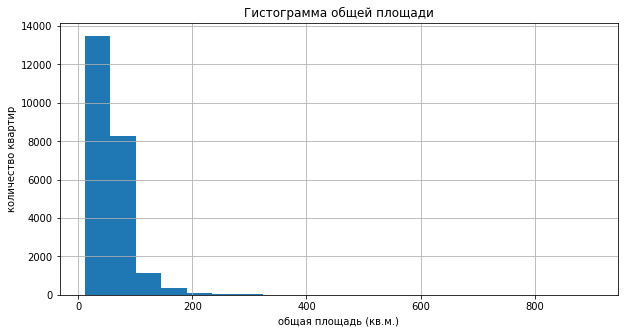

In [41]:
# построение гистограммы total_area

data['total_area'].hist(bins=20, range=(12,901),figsize=(10,5))
plt.title("Гистограмма общей площади")
plt.xlabel("общая площадь (кв.м.)")
plt.ylabel("количество квартир")
plt.show()

Гистограмма показывает, что более 21 тысячи строк имеют общую площадь от 12 до 100 квадратных метров. На графике отображаются значения от минимального (12кв.м.) до максимального (900кв.м.). В данном случае говорить о аномальности значений выше 100 кв.м. и максимального значения в 900 кв.м. мы не можем, так как действительно на рынке недвижимости может быть квартира с площадью 900 кв.м., с учетом наличия терассы или иных площадей, присущих элитному жилью.

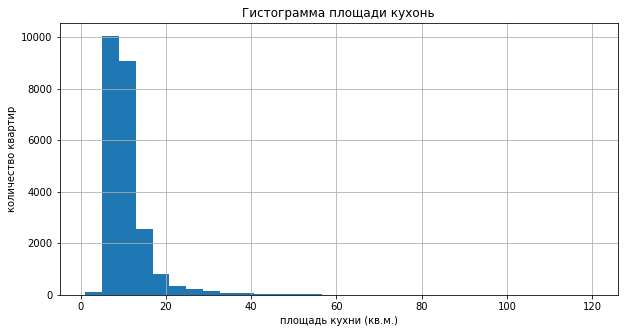

In [42]:
data['kitchen_area'].hist(range=(1,120), bins=30, figsize=(10,5))
plt.title("Гистограмма площади кухонь")
plt.xlabel("площадь кухни (кв.м.)")
plt.ylabel("количество квартир")
plt.show()

По площади кухонь, можно говорить о преобладании значений в области 10 кв.м., единичны значения выше 20 кв.м.

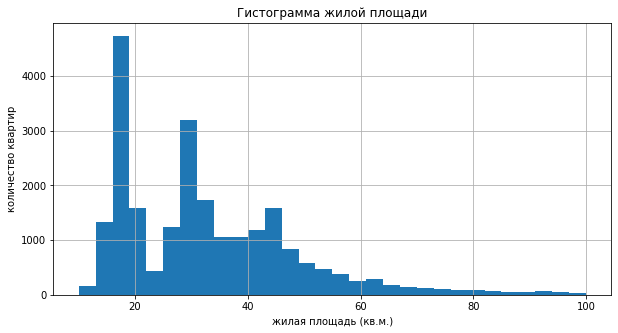

In [43]:
data['living_area'].hist(bins=30, range=(10,100), figsize=(10,5))
plt.title("Гистограмма жилой площади")
plt.xlabel("жилая площадь (кв.м.)")
plt.ylabel("количество квартир")
plt.show()

Максимальное количество квартир имеет жилую площадь до 20 кв.м., в целом, значения более 80 кв.м. уже единичны.

Рассмотрим гистограммы по столбцам living_area_ratio и kitchen_area_ratio, если их значения больше 1, значит относительно общей площади помещений кухни или жилая площадь больше общей, что говорит об ошибках в данных. Такие квартиры могут исказить аналитические выводы.

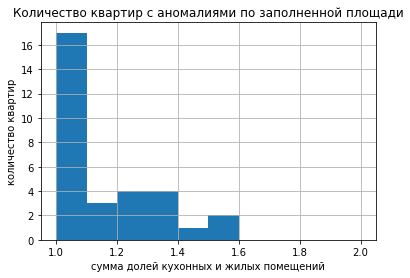

In [44]:
data['living_area_ratio'].hist(range=(1,2))
plt.title("Количество квартир с аномалиями по заполненной площади")
plt.xlabel("сумма долей кухонных и жилых помещений")
plt.ylabel("количество квартир")
plt.show()

Более 20 строк имеет долю жилой площади больше 1, что отражает некорректность представленных данных. Аналогично необходимо избавиться от строк с долей кухонной площади выше 1. Также, если сумма долей жилой площади и кухонной больше единицы, то это также является аномальным значением, так как в действительности такая ситуация невозможна. 

Очистим датасет от указанных аномальных значений.

In [45]:
# очистка данных от среза с аномальной долей площадей
print('Данных до отчистки от значений с аномальной площадью помещений:', data.shape[0])
data = data.query('(kitchen_area_ratio + living_area_ratio) <= 1')
print('Данных после отчистки:', data.shape[0])

Данных до отчистки от значений с аномальной площадью помещений: 23565
Данных после отчистки: 23175


По результатам анализа информации с квардратурой квартир было удалено 390 ошибочно посчитанных аномальных значений. Перейдем к анализу данных о высоте потолков **ceiling_height**

**Изучение высоты потолков**

In [46]:
data['ceiling_height'].describe()

count    23175.000000
mean         2.732765
std          0.965639
min          1.000000
25%          2.550000
50%          2.650000
75%          2.750000
max        100.000000
Name: ceiling_height, dtype: float64

Минимальная высота потолков - 1 метр, в реальности не существует жилых помещений с такой высотой потолков, что уже указывает на аномальность некоторых значений столбца. Также, максимальная высота 100м. - такой высоты может быть небоскреб 26-28 этажей. Средние и медианные значения выглядят правдоподобно, стандартная высота потолка в Российской высотке 2,7м, медианное значение 2,65, среднее - 2,73. Рассмотрим диаграмму размаха по высоте потолков

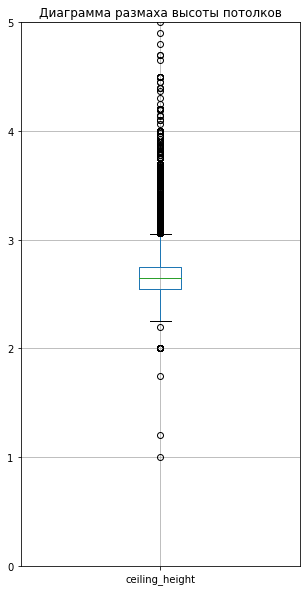

In [47]:
data.boxplot(column='ceiling_height', figsize=(5,10))
plt.ylim(0,5)
plt.title("Диаграмма размаха высоты потолков")
plt.show()

По диаграмме можно увидеть, что нижний ус (граница нормальных значений) находится примерно на 2,2 м, а верхняя граница примерно 3,1м, также, учитывая, что в Российской действительности высокими потолками считаются потолки 2,8-3,0 метра, посчитаем конкретные границы "усов" диаграммы размаха и определим аномальные значения

In [48]:
# функция расчета нижней и верхней границы неаномальных значений

def whiskers(row):
    first_q = row.quantile(0.25)
    third_q = row.quantile(0.75)
    whisker_lower = first_q - 1.5*(third_q - first_q)
    whisker_upper = third_q + 1.5*(third_q - first_q)
    return whisker_lower, whisker_upper

In [49]:
# определение границ нормальных значений
height_whiskers = whiskers(data['ceiling_height'])
print('Нижняя граница:', height_whiskers[0], 'Верхняя граница:', height_whiskers[1])

Нижняя граница: 2.2499999999999996 Верхняя граница: 3.0500000000000003


Мы получили, что нижняя граница 2,25м, а верхняя 3,05. Исходя из экспертной оценки, увеличим верхнюю границу до 3,6 м, так как в данных может быть небольшое количество "сталинок" с потолками до указанной границы. Исходя из градостроительной практики, высота потолков менее 2,3 метра не считается нормой, поэтому нижнюю границу оставим равной границе нормальных значений по построенной диаграмме.

Посчитаем количество аномальных значений, не входящих в указанный промежуток и удалим их из датасета.

In [50]:
print('Количество аномальных значений:', data.query('ceiling_height < 2.25 or ceiling_height > 3.6')['ceiling_height'].count())

Количество аномальных значений: 236


In [51]:
# очистка датасета от аномальных значений

print('Данных до отчистки от значений с аномальной высотой потолков:', data.shape[0])
data = data.query('ceiling_height >= 2.25 and ceiling_height <= 3.6')
print('Данных после отчистки:', data.shape[0])

Данных до отчистки от значений с аномальной высотой потолков: 23175
Данных после отчистки: 22939


**Изучение числа комнат в квартирах**

Далее рассмотрим распределение по количеству комнат. Изучим величины данного столбца:

In [52]:
data['rooms'].describe()

count    22939.000000
mean         2.077597
std          1.051633
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Минимальное количество комнат равно одной, среднее - 2, 3ий квантиль - это 3 комнаты, максимальное количество - 19. Указанное значение выглядит аномальным. Посмотрим на диаграмму размаха, чтобы определить значения, выходящие из "ящика с усами".

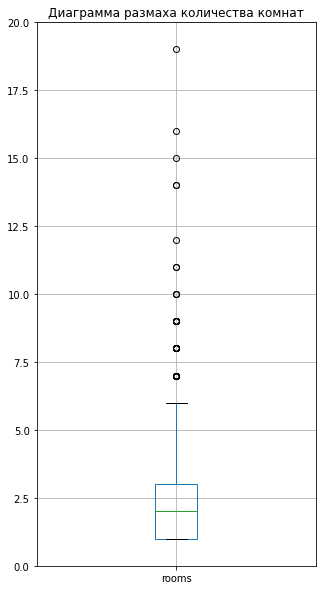

In [53]:
data.boxplot(column='rooms', figsize=(5,10))
plt.ylim(0,20)
plt.title('Диаграмма размаха количества комнат')
plt.show()

Согласно диаграмме размаха, нормальными значаниями являются квартиры с количеством от 1 до 6 комнат, в действительности, комнат может быть больше, в зависимости от планировки, разграничений, площади квартиры и так далее. Рассмотрим данные с количеством комнат больше 6 и посмотрим на медианное и среднее значение жилой площади помещения.

In [54]:
# создаем сводную таблицу с группировкой по количеству комнат (больше 6), по значениям жилая площадь
data_rooms = (data
              .query('rooms > 6')
              .pivot_table(index='rooms', values='living_area', aggfunc=['mean','median'])
             )
data_rooms.reset_index(inplace=True)

# добавляем столбцы с расчетом среднего и медианого значения размера комнат для каждой группы квартир
data_rooms['room_size_by_mean'] = data_rooms['mean', 'living_area'] / data_rooms['rooms']
data_rooms['room_size_by_median'] = data_rooms['median', 'living_area'] / data_rooms['rooms']

data_rooms

,rooms,mean,median,room_size_by_mean,room_size_by_median
,,living_area,living_area,,
0,7,150.493750,145.00,21.499107,20.714286
1,8,153.577778,160.00,19.197222,20.000000
2,9,188.875000,179.20,20.986111,19.911111
3,10,165.566667,161.40,16.556667,16.140000
4,11,133.900000,133.90,12.172727,12.172727
5,12,409.700000,409.70,34.141667,34.141667
6,14,195.150000,195.15,13.939286,13.939286
7,15,409.000000,409.00,27.266667,27.266667
8,16,180.000000,180.00,11.250000,11.250000


Несмотря на то, что значения больше 6 комнат в квартире считаются согласно диаграмме размаха аномальными, мы видим, что средняя площадь комнат в квартирах с более 6 комнатами выглядит более чем реалистично. Посмотрим на количество таких значений

In [55]:
data.query('rooms > 6')['rooms'].count()

76

Таких данных слишком мало, чтобы рассчитывать на их пользу в исследовании. Наиболее правильным действием будет очистка датасета от аномалии по количеству комнат.

In [56]:
# очистка от аномальных значений по количеству комнат

data = data.query('rooms <= 6')

**Изучение цен**

Перейдем к изучению данных о цене квартир. Ранее мы добавили информацию о стоимости 1 квадратного метра квартиры в столбец **square_meter_price**

In [57]:
data['square_meter_price'].describe().round(0)

count      22863.0
mean       98651.0
std        47714.0
min          111.0
25%        76295.0
50%        94700.0
75%       113736.0
max      1736842.0
Name: square_meter_price, dtype: float64

По статистическим величинам уже можно сказать, что в данных имеются явно выраженные аномалии. В жизни не встретишь квартиры со стоимостью 111 рублей за квадратный метр и 1 907 500 за один квадратный метр. Медиана и средняя выглядят правдоподобными, первый квантиль и третий квантиль также соответствуют значениям на рынке недвижимости. Рассмотрим гистограмму:

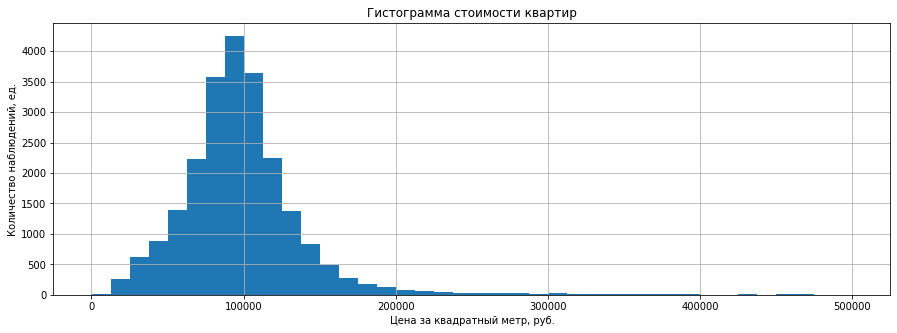

In [58]:
data['square_meter_price'].hist(bins=40, figsize=(15,5), range=(0,500000))
plt.title("Гистограмма стоимости квартир")
plt.xlabel("Цена за квадратный метр, руб.")
plt.ylabel('Количество наблюдений, ед.')
plt.show()

Гистограмма соответствует форме нормального распределения, пик частоты выпадает на цену 90-100 тысяч за квадратный метр. Однако, мы видим слишком маленькие значения рядом с нулем и возникновение невысоких частот при цене свыше 200 тысяч. Для поиска аномальных значений рассмотрим диаграмму размаха.

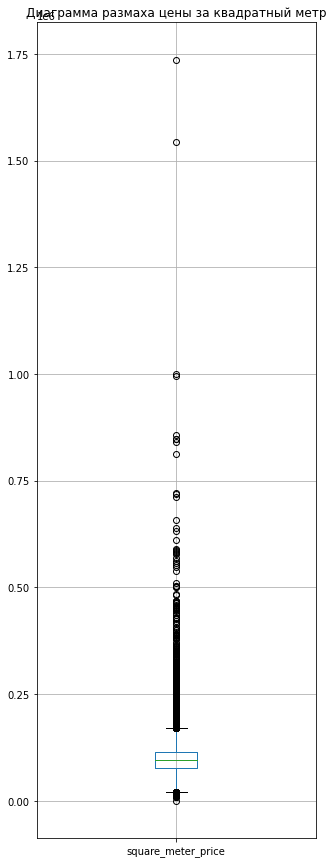

In [59]:
data.boxplot(column='square_meter_price', figsize=(5,15))
plt.title("Диаграмма размаха цены за квадратный метр")
plt.show()

Посмотрим, сколько значений соответствует расстоянию 1,5 IQR

In [60]:
# определение границ нормальных значений
sqm_whiskers = whiskers(data['square_meter_price'])

print('Нижняя граница неаномальных значений:', sqm_whiskers[0], 'Верхняя граница неаномальных значений:', sqm_whiskers[1])

Нижняя граница неаномальных значений: 20134.25 Верхняя граница неаномальных значений: 169896.25


In [61]:
data.query('square_meter_price < @sqm_whiskers[0] or square_meter_price > @sqm_whiskers[1]').shape[0]

1028

Получаем 1028 строк с выбросами. Это примерно 4,5% от текущего числа объявлений в датасете. Оптимальным решением будет очистка датасета от значений с выбросами, так как в дальнейшей работе мы будем сравнивать стоимость квадратного метра квартир с другими факторами и именно эта информация должна быть наиболее очищенной от выбросов, чтобы выводы были корректными.

In [62]:
# очистка датасета от аномальных цен на квартиры

data = data.query('square_meter_price >= @sqm_whiskers[0] and square_meter_price <= @sqm_whiskers[1]')

**Вывод по анализу значений и выявлению аномалий**

Мы провели анализ некоторых показателей, описывающих квартиры в объявлениях.

- были выявлены объявления с некорректно посчитанной площадью помещений, на основе рассчитанных ранее долей площади жилой квадратуры и доли площади кухонь, мы убрали те строки, где сумма долей превышает общую площадь помещения.
- в столбце высота потолков были найдены аномальные значения. При медианном и среднем значении потолков 2,6-2,7 метров, соответствующему реальным данным при строительстве жилых домов, в датасете имелись данные с квартирами, где потолки меньше 2 метров, и выше 3,6 метров. Верхнюю границу для поиска аномалии мы определили отличную от верхней границы, определенной в диаграмме размаха, так как в реальной жизни встречаются сталинские дома, где высота потолков равна 3,6 метрам. Аномальные значения были удалены из датасета.
- при изучении информации о количестве комнат, было выявлено 76 строк со значением комнат больше 6, несмотря на то, что 76 строк - это ничтожно маленькое количество относительно общего числа объявлений в датасете, а также средние величины комнат в квартирах с количеством комнат превышающем характерный разброс могут соответствовать реальным данным, было решено очистить датасет от найденных выбросов.
- при оценке стоимости квадратного метра в продаваемых квартирах мы также воспользовались диаграммой размаха и гистограммой частот для определения адекватных значений. Более тысячи строк оказались выбросами и были удалены из датасета для качественных расчетов и поиска ответов на поставленные в исследовании вопросы.

**Изучение времени продажи квартир**

Рассмотрим время продажи квартир и ответим на следующие вопросы:

- Сколько времени обычно занимает продажа? 
- Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?

Для начала построим гистограмму для данных о времени продажи квартиры (столбец **days_exposition**), убрав объявления, где продажа еще не совершена

In [64]:
# очистка датасета от объявлений без продажи

data_filtered = data.query('days_exposition.isna() == False')

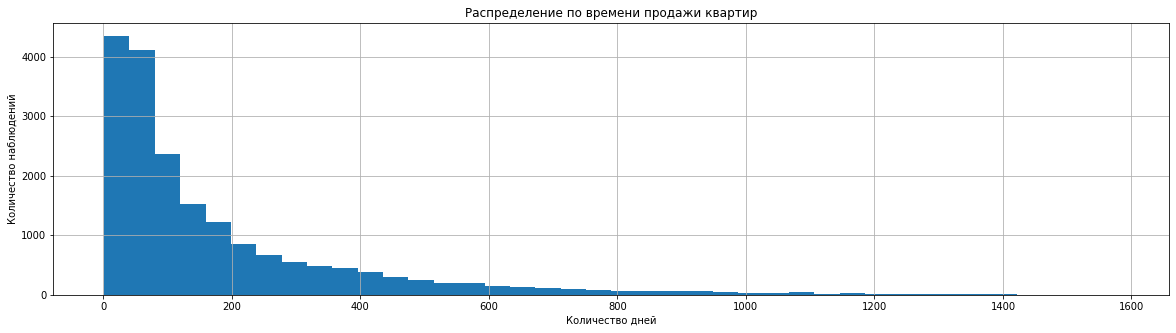

In [65]:
data_filtered['days_exposition'].hist(bins=40, figsize=(20,5))
plt.title("Распределение по времени продажи квартир")
plt.xlabel("Количество дней")
plt.ylabel('Количество наблюдений')
plt.show()

Пиковое распределение объявлений по времени продажи квартир приходится на значения до 50 дней. Рассмотрим отрезок с наибольшим распределнием

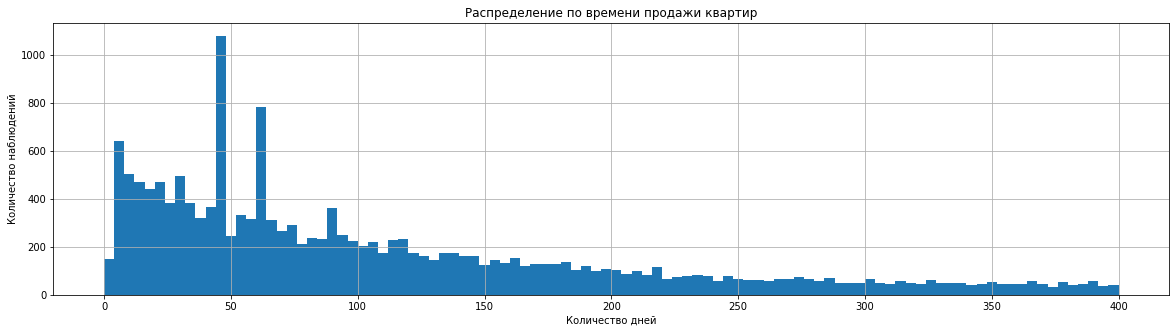

In [66]:
data_filtered['days_exposition'].hist(bins=100, range=(0,400), figsize=(20,5))
plt.title("Распределение по времени продажи квартир")
plt.xlabel("Количество дней")
plt.ylabel('Количество наблюдений')
plt.show()

Из гистограммы следует, что в среднем, необходимо 40 дней на продажу. Для получения конкретных статистических показателей применим метод describe() к столбцу и сравним с полученными данными в гистограммах.

In [67]:
data_filtered['days_exposition'].describe()

count    19016.000000
mean       179.231384
std        218.254106
min          1.000000
25%         45.000000
50%         95.000000
75%        228.000000
max       1580.000000
Name: days_exposition, dtype: float64

Медианное значение - 95 дней. Это означает, что 50% наблюдений находится до 95 дней и 50% больше. Также, нестандатрно быстрым выглядит минимальное значение продажи квартир, равное одному дню, возможно, это объявления, которые были ошибочно опубликованы и поэтому сняты пользователями. Для определения границ нормальных значений воспользуемся как и раньше диаграммой размаха.

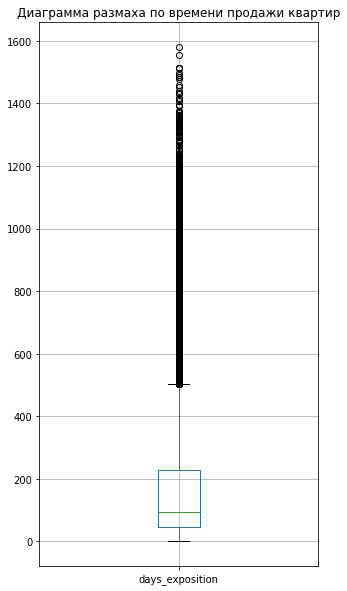

In [68]:
data_filtered.boxplot(column='days_exposition', figsize=(5,10))
plt.title("Диаграмма размаха по времени продажи квартир")
plt.show()

Можно сделать вывод, что продажа квартиры обычно происходит в срок от 45 до 228 дней, реже встречаются объявления, где продажа занимает от 0 до 45 дней и от 228 до 500. Аномально долгими продажами можно назвать объявления, висящие более 500 дней.
Стоит учитывать, что в срез объявлений, которые сняты в срок до 45 дней могут входить те, которые сняты не по причине продажи, а в связи с перепубликацией или иными причинами, по которым пользователь решил снять объявление с сайта.

**Выявление факторов, влияющих на стоимость**

Для поиска факторов, влияющих на стоимость квартир, определим:
- зависимость цены от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. 
- зависимость от даты размещения: дня недели, месяца и года. 
- населенные пункты с самой высокой и низкой стоимостью жилья.
"Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце 'locality_name'. "

Для выявления факторов и оценки из зависимости выделим необходимые столбцы в отдельный датафрейм

In [69]:
data_price = data_filtered[['last_price', 'square_meter_price', 'rooms', 'floor_category', 'city_centers_nearest', 'exposition_day', 'exposition_month', 'exposition_year', 'locality_name', 'total_area']]
data_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19016 entries, 1 to 23697
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   last_price            19016 non-null  float64
 1   square_meter_price    19016 non-null  int32  
 2   rooms                 19016 non-null  int64  
 3   floor_category        19016 non-null  object 
 4   city_centers_nearest  14714 non-null  float64
 5   exposition_day        19016 non-null  int64  
 6   exposition_month      19016 non-null  int64  
 7   exposition_year       19016 non-null  int64  
 8   locality_name         19016 non-null  object 
 9   total_area            19016 non-null  float64
dtypes: float64(3), int32(1), int64(4), object(2)
memory usage: 1.5+ MB


In [70]:
# расчет коэффициентов корреляции

data_price.corr()

,last_price,square_meter_price,rooms,city_centers_nearest,exposition_day,exposition_month,exposition_year,total_area
last_price,1.000000,0.549096,0.553196,-0.322508,-0.007910,0.012014,-0.063508,0.837038
square_meter_price,0.549096,1.000000,-0.122124,-0.398493,-0.004769,0.009247,0.049152,0.066713
rooms,0.553196,-0.122124,1.000000,-0.154487,-0.006487,0.003134,-0.087085,0.771147
city_centers_nearest,-0.322508,-0.398493,-0.154487,1.000000,0.006622,-0.014417,0.031839,-0.192000
exposition_day,-0.007910,-0.004769,-0.006487,0.006622,1.000000,0.007736,0.006812,-0.006919
exposition_month,0.012014,0.009247,0.003134,-0.014417,0.007736,1.000000,-0.198535,0.005055
exposition_year,-0.063508,0.049152,-0.087085,0.031839,0.006812,-0.198535,1.000000,-0.101966
total_area,0.837038,0.066713,0.771147,-0.192000,-0.006919,0.005055,-0.101966,1.000000


Рассмотрим диаграмму рассеяния для общей площади квартир и цены за квадратный метр

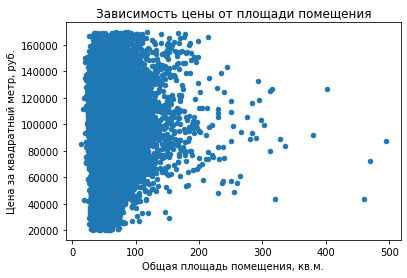

In [71]:
data_price.plot(x='total_area', y='square_meter_price', kind='scatter')
plt.title('Зависимость цены от площади помещения')
plt.xlabel("Общая площадь помещения, кв.м.")
plt.ylabel('Цена за квадратный метр, руб.')
plt.show()

По диаграмме видно, что площадь квартир и цена за квадратный метр не имеет выраженной зависимости, что логично, так как большие квартиры в малонаселенных и отдаленных от Санкт-Петербурга населенных пунктах могут стоить меньше, чем небольшие квартиры в центре города. Изучим зависимость цены от числа комнат

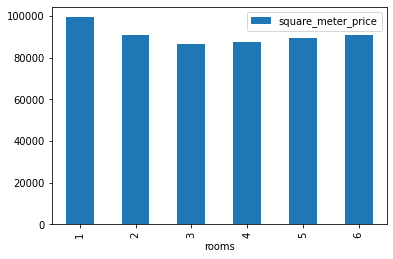

In [72]:
(data_price
         .pivot_table(index='rooms', values='square_meter_price', aggfunc='median')
         .plot(y='square_meter_price',kind='bar')
)
plt.show()

По графику видим, что стоимость квадратного метра в однокомнатных квартирах выше, чем других типах квартир, самая низкая стоимость квадратного метра у трехкомнатных квартир.

Это может быть связано с тем, что однокомнатные квартиры пользуются наибольшим спросом, как более доступное жилье по стоимости. В то же время, трехкомнатные квартиры менее свойственны для элитных жилых комплексов, где комнат может быть больше, что может свидетельствовать о большей доступности такого типа квартир.

Рассмотрим зависимость цен за квадратный метр и этажности квартиры

In [73]:
(data_price
         .pivot_table(index='floor_category', values='square_meter_price', aggfunc='median')
         .reset_index()
)

,floor_category,square_meter_price
0,другой,96004.0
1,первый,80152.0
2,последний,86347.5


Стоимость квадратного метра квартир на первом этаже самая низкая, можно говорить о зависимости стоимости квартиры от расположения в доме. На последнем этаже стоимость также ниже, чем квартиры с этажом категории "другой".

Первый этаж считается менее привлекательным для потребителей на рынке недвижимости, так как это означает отсутствие видов из окна, возможный дискомфорт проживания рядом с дорогами и проезжей частью, запах и сырость из подвала здания.
Последний этаж также менее привлекателен, так как возможны риски протечки крыши, более низкие температуры в помещении.

Рассмотрим, как меняется цена за квадратный метр в зависимости от удаленности квартиры от центра

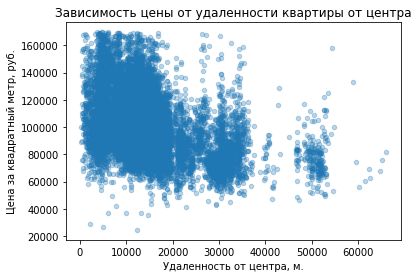

In [74]:
data_price.plot(x='city_centers_nearest', y='square_meter_price', kind='scatter', alpha=0.3)
plt.title('Зависимость цены от удаленности квартиры от центра')
plt.xlabel("Удаленность от центра, м.")
plt.ylabel('Цена за квадратный метр, руб.')
plt.show()

По полученной диаграмме можно сделать вывод, что наиболее число наблюдений находится в пределах 35 тыс. метров от центра.

Без использования средних значений коэффициент Пирсона равен -0,57, что говорит об обратной зависимости факторов. При росте цены уменьшается расстояние до центра.

Посмотрим, как меняется средняя стоимость при размещении объявления в разные дни недели, месяцы, года.

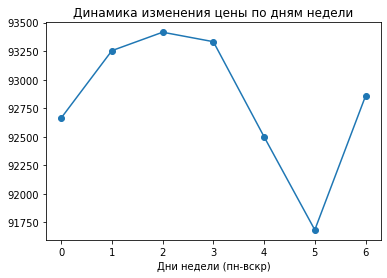

In [104]:
(data_price
     .pivot_table(index='exposition_day', values='square_meter_price', aggfunc='median')
     .reset_index()
     .plot(x='exposition_day', y='square_meter_price', style='o-', legend=False)
)
plt.title('Динамика изменения цены по дням недели')
plt.xlabel("Дни недели (пн-вскр)")
plt.show()

По графику видно, что средняя стоимость в субботу почти на 2 тыс. руб. ниже, однако в данном случае мы не можем говорить о сильном влиянии, так как суммарная разница 1-2%. Сделаем тоже самое для года публикации и месяца.

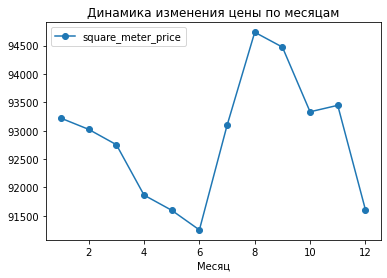

In [76]:
# динамика цен в зависимости от месяца публикации

(data_price
     .pivot_table(index='exposition_month', values='square_meter_price', aggfunc='median')
     .reset_index()
     .plot(x='exposition_month', y='square_meter_price', style='o-')
)
plt.title('Динамика изменения цены по месяцам')
plt.xlabel("Месяц")
plt.show()

Наименьшая стоимость жилья наблюдается в июне, и далее идет рост к августу, где цена достигает пикового значения. Можно связать данную тенденцию с началом учебного года и окончанием отпусков. Люди начинают осуществлять планы на следующий рабочий\учебный год.

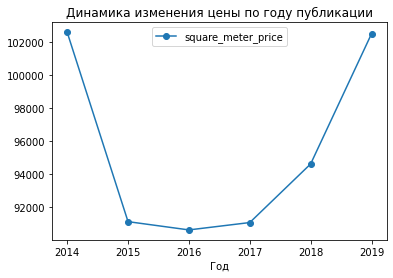

In [77]:
# динамика цен в зависимости от года публикации

(data_price
     .pivot_table(index='exposition_year', values='square_meter_price', aggfunc='median')
     .reset_index()
     .plot(x='exposition_year', y='square_meter_price', style='o-')
)
plt.title('Динамика изменения цены по году публикации')
plt.xlabel("Год")
plt.show()

По графику отчетливо видно, что в 2014 году стоимость жилья была самой высокой, это связано с экономическими и политическими факторами. Данный период эксперты называют кризисным в том числе для рынка недвижимости в России. Затем, наблюдается спад, что также соответствует экономическим тенденциям, представленным в экспертных оценках на экономических информационных порталах и далее следует резкий рост цен в 2019 году.

Рассмотрим количество наблюдении в 2014 году и среднюю стоимость квартир

In [78]:
data_price.query('exposition_year == 2014')['square_meter_price'].describe()

count       104.000000
mean     102107.701923
std       34609.425743
min       20338.000000
25%       79453.500000
50%      102623.000000
75%      132231.500000
max      167085.000000
Name: square_meter_price, dtype: float64

Всего 104 объявления от 2014 года из 19 тысяч строк, что делает данные за 2014 не репрезентативными и непригодными для сравнения в связи с маленьким объемом выборки.

Рассматривая данные о недвижимости в Ленинградской области, определим населенные пункты с самой высокой и низкой стоимостью жилья. Для этого из более чем 300 уникальных значений локаций выделим 10 с наибольшим числом объявлений. 

In [79]:
# 10 наиболее встречаемых локаций в объявлениях

top_10 = data_filtered['locality_name'].value_counts().head(10)
top_10

Санкт-Петербург    12535
Мурино               502
Кудрово              405
Шушары               399
Всеволожск           327
Колпино              304
Пушкин               300
Парголово            299
Гатчина              259
Выборг               197
Name: locality_name, dtype: int64

Больше половины датасета - это объявления о продаже квартир в Санкт-Петербурге. Создадим датафрейм с указанными локациями и посчитаем среднюю цену квадратного метра для них.

In [80]:
# получение датасета data_top_10 с часто встречаемыми населенными пунктами

top_10 = top_10.index
data_top_10 = data_filtered[data_filtered['locality_name'].isin(top_10)]

Посчитаем среднюю цену квадратного метра в этих населённых пунктах

In [99]:
# медиана и средняя цена за кв.м. в топ-10 населенных пунктах

data_top_10.pivot_table(index='locality_name', values='square_meter_price', aggfunc=['median', 'mean']).sort_values(by=('median','square_meter_price'), ascending=False)

,median,mean
,square_meter_price,square_meter_price
locality_name,,
Санкт-Петербург,101562.0,104646.859114
Пушкин,97725.5,100876.220000
Кудрово,93575.0,93780.972840
Парголово,91428.0,89671.367893
Мурино,84262.0,84929.346614
Шушары,75757.0,77438.491228
Колпино,74005.0,74725.736842
Гатчина,67187.0,68502.494208


Таким образом, самая высокая средняя стоимость жилья в Санкт-Петербурге, за ним идет город Пушкин и Кудрово. Логично, что в столице самая высокая стоимость жилья, самая низкая стоимость жилья в городе Выборг.

**Вывод по факторам, влияющим на стоимость недвижимости**

1. Наибольшее влияние на стоимость недвижимости оказывает удаленность недвижимости от центра, чем дальше квартира от центра области, тем меньше стоимость квадратного метра.
2. В зависимости от месяца меняется стоимость продажи квартир, в августе наблюдается пиковое значение средней стоимости недвижимости, который постепенно снижается к зимнему периоду. Данная тенденция свидетельствует о большем спросе на недвижимость в теплое время года перед началом учебного года и осеннего периода, когда людиработе обычно меняют место учебы/работы.
3. Квартиры на первом этаже имеют самую низкую стоимость, самая высокая цена за квартиры, расположенные не на последнем и не на первом этаже, причинами могут быть желание иметь красивый вид и отсутствие рисков, связанных с расположением на последнем этаже под кровлей.
4. В зависимости от числа комнат наблюдаются незначительные изменения при их вариативности, однако, можно выделить, что однокомнатные квартиры имеют наибольшую цену за квадратный метр, что связано с повышенным спросом на однокомнатные квартиры, как более доступное жилье, и общим распределением себестоимости недвижимости на меньшую общую площадь.
5. На графике изменения средних цен в зависимости от года публикации объявления видны особенности, связанные с экономической ситуацией в стране. В 2014 году были пиковые значения средней стоимости квадратного метра недвижимости в связи с кризисной ситуацией и проблемами во внешнеэкономическом пространстве, далее был спад цен до 2016 года, на что могли повлиять новые ипотечные программы и появление более доступных программ для приобретения жилья на первичном рынке, затем наблюдается постепенный рост, который ускорил темпы с 2017 по 2019 год, в 2019 году также ситуация на рынке недвижимости ухудшилась и заметен рост цен на жилую недвижимость.
6. Проанализировав населенные пункты с наибольшим количеством объявлений, мы выявили, что больше половины объявлений о недвижимости в Санкт-Петербурге, остальные города имеют менее 510 объявлений. Самая высокая стоимость недвижимости в Северной столице, самая низкая - в городе Выборг.

**Изучение предложения квартир (выявление центральной области)**

Изучим предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделим квартиры в Санкт-Петербурге ('locality_name'), чтобы выяснить, какая область входит в центр. 

Первым шагом возьмем срез данных, где указана информация только о квартирах в Санкт-Петербурге, изменим данные с информацией о дистанции до центра, переведем данные в киллометры.

In [82]:
data_spb = data_filtered.query('locality_name == "Санкт-Петербург"')

In [83]:
# создание столбца с расстоянием до центра в киллометрах

data_spb['city_centers_nearest_km'] = (data_spb['city_centers_nearest'] / 1000).astype(int)

Выведем несколько строк полученного датасета

In [84]:
data_spb.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3_km,parks_nearest,ponds_around_3_km,ponds_nearest,days_exposition,square_meter_price,exposition_day,exposition_month,exposition_year,floor_category,living_area_ratio,kitchen_area_ratio,city_centers_nearest_km
5273,10,4500000.0,53.00,2018-10-18,1,2.70,25,14.00,22,0,0,0,13.00,1,Санкт-Петербург,48847.0,16685.0,0,455.0,0,503.0,62,84905,3,10,2018,другой,0.2642,0.2453,16
6036,1,7066624.0,51.20,2016-05-12,1,3.10,16,26.13,9,0,0,0,11.41,0,Санкт-Петербург,37407.0,8434.0,1,456.0,2,454.0,54,138020,3,5,2016,другой,0.5104,0.2229,8
18581,20,3525000.0,36.39,2016-03-11,1,2.70,17,16.00,5,0,0,0,8.63,0,Санкт-Петербург,43254.0,12012.0,0,455.0,0,503.0,369,96867,4,3,2016,другой,0.4397,0.2372,12
9614,6,6600000.0,54.00,2017-08-08,2,2.96,5,30.50,4,0,0,0,8.70,0,Санкт-Петербург,28781.0,7720.0,2,21.0,2,220.0,261,122222,1,8,2017,другой,0.5648,0.1611,7
13796,20,13300000.0,88.00,2016-03-01,3,2.75,20,47.30,10,0,0,0,20.00,0,Санкт-Петербург,29780.0,7152.0,0,455.0,1,445.0,224,151136,1,3,2016,другой,0.5375,0.2273,7


Рассчитаем среднюю цену квадратного метра в зависимости от удаленности от центра

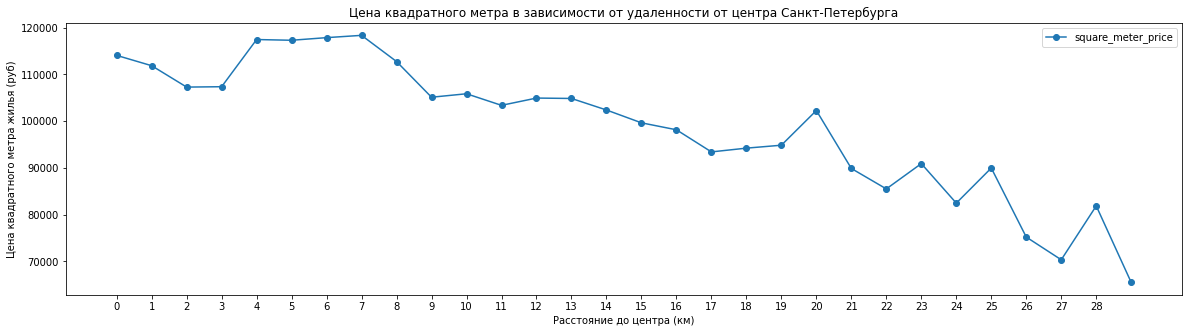

In [85]:
# средняя цена кв.м. квартир в зависимости от удаленности от центра

data_spb_avg = data_spb.pivot_table(index='city_centers_nearest_km', values='square_meter_price', aggfunc='mean').reset_index()
data_spb_avg.plot(x='city_centers_nearest_km', y='square_meter_price', style='o-',figsize=(20,5))
plt.xticks(range(0,29,1))
plt.title('Цена квадратного метра в зависимости от удаленности от центра Санкт-Петербурга')
plt.xlabel('Расстояние до центра (км)')
plt.ylabel('Цена квадратного метра жилья (руб)')
plt.show()

По графику видно, что чем ближе квартира к центру, тем дороже стоимость. Но виден всплеск в промежутках от 4 до 7 км удаленности от центра, где цена за квадратный метр самая высокая. Согласно информации порталов о недвижимости, в данном промежутке располагаются новостройки премиум сегмента.

Значительный спад значений наблюдается при расстоянии от 9км и больше, будем считать центральной зону 0-8 км

Таким образом, мы выделили сегмент квартир в центре - это недвижимость на расстоянии 8 км от центра города. Проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков. 

In [86]:
# выделение среза квартир в центре

data_spb_center = data_spb.query('city_centers_nearest_km <= 8')
data_spb_center.shape[0]

2931

В срез попало 2931 значений, рассмотрим площадь квартир в данном сегменте

In [87]:
data_spb_center[['total_area','kitchen_area','living_area']].describe()

,total_area,kitchen_area,living_area
count,2931.000000,2931.000000,2931.000000
mean,76.739188,12.110894,44.635254
std,38.592847,6.504112,25.086123
min,17.000000,2.000000,2.000000
25%,49.500000,8.300000,28.000000
50%,69.000000,10.200000,40.000000
75%,93.000000,14.000000,55.300000
max,494.100000,100.700000,300.000000


Медианное значение общей площади квартиры - 52 кв.м., что похоже на правду, из которых 30 кв.м. жилых помещений и 9 кв.м. - кухня" - такие данные были в общем по Ленинградской области.

Мы видим, что в центре Питера значения несколько изменились, средняя квадратура квартир стала значительно больше. Медианные значения: общая площадь - 69, жилые помещени - 40, кухня - 10,2. В центре Санкт-Петербурга квартиры более просторные

In [89]:
data_spb_center['rooms'].describe()

count    2931.000000
mean        2.546912
std         1.133766
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: rooms, dtype: float64

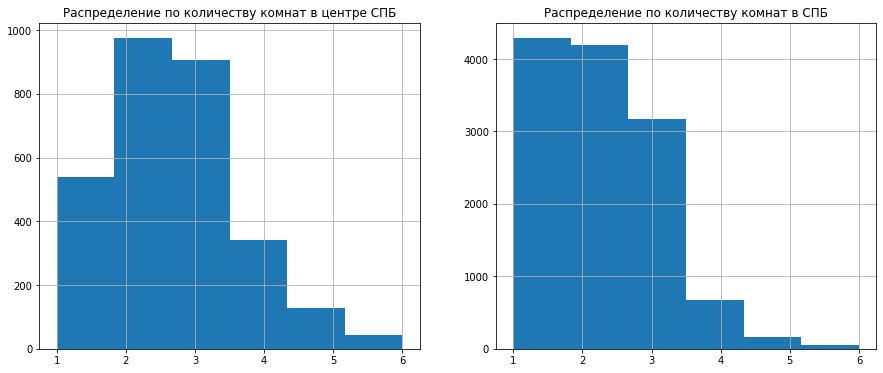

In [102]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

data_spb_center['rooms'].hist(bins=6, ax=axes[0])
data_spb['rooms'].hist(bins=6, ax=axes[1])

axes[0].set_title('Распределение по количеству комнат в центре СПБ')
axes[1].set_title('Распределение по количеству комнат в СПБ')
plt.show()

При рассмотрении среднего количества комнат в квартирах, изменилось значение первого квартиля, в случае просмотра данных по всей области, количество комнат, отделяющее первую четверть выборки было 1, в центре Питера квартиль увеличился до 2, что свидетельствует о том, что квартиры в центре Питера в среднем имеют больше комнат.

In [91]:
data_spb_center['ceiling_height'].describe()

count    2931.000000
mean        2.869614
std         0.275647
min         2.400000
25%         2.600000
50%         2.800000
75%         3.000000
max         3.600000
Name: ceiling_height, dtype: float64

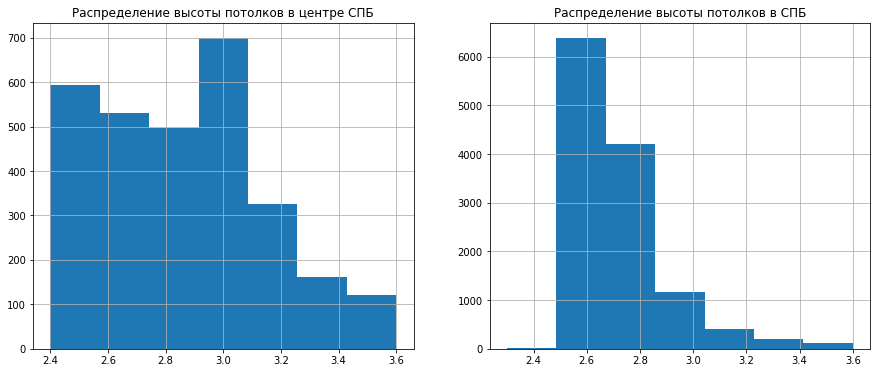

In [108]:
fig, axes = plt.subplots(1,2,figsize=(15,6))

data_spb_center['ceiling_height'].hist(bins=7, ax=axes[0])
data_spb['ceiling_height'].hist(bins=7, ax=axes[1])

axes[0].set_title('Распределение высоты потолков в центре СПБ')
axes[1].set_title('Распределение высоты потолков в СПБ')
plt.show()

Аналогично с высотой потолков, если по области среднее значение высоты потолков было 2,65 метров, то в центре Питера высота потолков значительно выше, здесь медиана равна 2,8 метрам, а нижняя граница по области, с учетом отсечки аномальных значений, равнялась 2,25м, в центре данный показатель 2,4.

В центре квартиры просторнее, потолки выше, комнат больше. Рассмотрим как отличается влияние различных факторов на стоимость квартир в центре.

In [93]:
# создание датасета с факторами для анализа

data_spb_price = data_spb_center[['square_meter_price', 'rooms', 'floor_category', 'exposition_day', 'exposition_month', 'exposition_year', 'locality_name', 'total_area', 'city_centers_nearest_km']]

# расчет корреляции по различным факторам для центра Петербурга
data_spb_price.corr()

,square_meter_price,rooms,exposition_day,exposition_month,exposition_year,total_area,city_centers_nearest_km
square_meter_price,1.000000,-0.315868,0.004319,-0.029884,0.074865,-0.131871,0.061390
rooms,-0.315868,1.000000,-0.019404,0.007513,-0.099830,0.768789,-0.286273
exposition_day,0.004319,-0.019404,1.000000,0.041860,0.008382,0.002148,0.027433
exposition_month,-0.029884,0.007513,0.041860,1.000000,-0.183513,0.003443,-0.002210
exposition_year,0.074865,-0.099830,0.008382,-0.183513,1.000000,-0.110911,0.084110
total_area,-0.131871,0.768789,0.002148,0.003443,-0.110911,1.000000,-0.240416
city_centers_nearest_km,0.061390,-0.286273,0.027433,-0.002210,0.084110,-0.240416,1.000000


По таблице с коэффициентами корреляции Пирсона мы видим, что явные зависимости отсутствуют и коэффициенты близки к нулевому значению, единственный коэффициент, показывающий наличие связи, это обратная зависимость стоимости квадратного метра от количества комнат в квартире. Построим графики для наглядного изучения влияния выделенных факторов и сопоставим с медианными значениями стоимости квадратного метра, чтобы увидеть реальное влияние внешних факторов на стоимость жилья.

Для начала рассмотрим влияние этажности квартиры:

In [94]:
(data_spb_price
         .pivot_table(index='floor_category', values='square_meter_price', aggfunc='median')
         .reset_index()
)

,floor_category,square_meter_price
0,другой,115747.0
1,первый,101621.5
2,последний,106818.0


В центре средняя цена в целом выше, но закономерность прослеживается одинаковая, стоимость квартир на первом и последнем этаже ниже, чем на любом другом. Влияние данного фактора совпадает с общей тенденцией.

Изучим влияние дня недели, месяца и года публикации объявления на среднюю стоимость квартиры

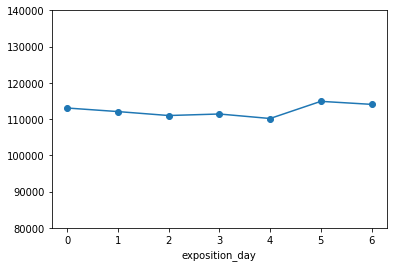

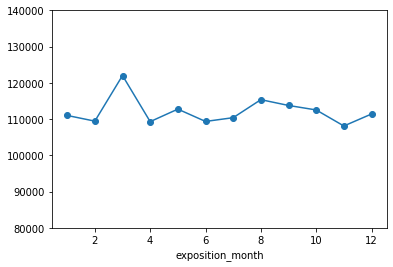

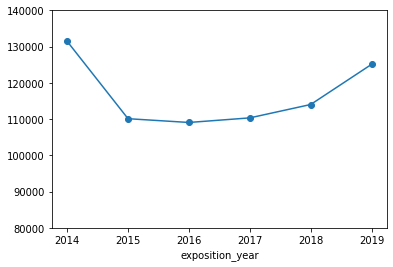

In [109]:
data_spb_price_date = data_spb_price[['square_meter_price', 'exposition_day', 'exposition_month', 'exposition_year']]

# построение графиков для дня, месяца, года
for column in data_spb_price_date.columns:
    if column != 'square_meter_price':
        (data_spb_price_date
            .pivot_table(index=column, values='square_meter_price', aggfunc='median')
            .reset_index()
            .plot(x=column, y='square_meter_price', style='o-', legend=False)
        )
        plt.ylim(80000,140000)
    plt.show()

По диаграммам видно, что цена в зависимости от года менялась аналогично, она была пиковой в 2014 и затем, после снижения до 2016 года постепенно растет.

Влияние месяца на стоимость квартиры в данном случае другое, пиковое значение средней стоимости за квадратный метр в центре Петербурга наблюдается в марте, а не в июле, как было по данным всей области.

День публикации, аналогично анализу общих данных, практически не имеет влияния на стоимость квартир.

Рассмотрим график по изменению стоимости за квадратный метр при различном числе комнат в квартире.

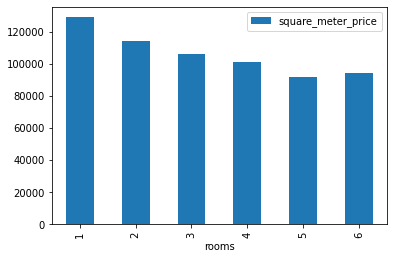

In [96]:
(data_spb_price
         .pivot_table(index='rooms', values='square_meter_price', aggfunc='median')
         .plot(y='square_meter_price',kind='bar')
)
plt.show()

Для квартир в центре, чем больше в помещении комнат, тем дешевле квадратный метр квартиры. Это можно обосновать заложенным издержкам на квадратный метр помещения, и соответственно, чем меньше площадь квартиры, тем больше стоимость квадратного метра в ней.

Также, аналогично общей ситуации, самая дорогая цена за квадратный метр, со значительным отличием от другой недвижимости, в однокомнатных квартирах. Опять же, можно сделать предположение о высоком спросе на однокомнатные квартиры.

**Вывод о влиянии факторов на стоимость квартир в центре Санкт-Петербурга**

Мы выявили, что в соответствии с увеличением растояния до центра уменьшается стоимость квадратного метра. Учитывая выброс пиковых значений стоимости в диапазоне 4-7км от центральной точки города, был определен срез квартир в центре города, в который вошло почти 3 тысячи наблюдений.

Квартиры в центре имеют большие показатели средней квадратуры, высоты потолков, комнатуры и цены за квадратный метр, чем средние показатели по всей Ленинградской области.

При изучении отличий влияния различных факторов на стоимость квартир в центре от квартир по всей области, получен вывод о совокупном соответствии влияния факторов. Из явно выраженных отличий было определено только то, что самая высокая средняя стоимость квартир в центре была указана в марте, а не в июле, как для всей Ленинградской области.

## Общий вывод

По результатам анализа получены следующие выводы:
- Чем дальше квартира от центра Санкт-Петербурга, тем меньше стоимость квадратного метра.
- Квартиры в центральной зоне Санкт-Петербурга имеют самую высокую стоимость за квадратный метр, при том, что пиковые значения стоимости находятся на расстоянии 4-7км от самого центра города, где предположительно находятся элитные жилые комплексы.
- Квартиры в центре Питера в среднем имеют большие размеры, чем в целом по всей Ленинградской области.
- Пиковые значения стоимости квартир наблюдаются в июле (для всех данных), и в марте (для центральной части).
- Квартиры на первом этаже имеют самую низкую стоимость, самая высокая цена за квартиры, расположенные не на последнем и не на первом этаже, так как отсутствуют риски, связанные с протекающей крышей и отсутствует сырость из-за близости к подвальным помещениям.
- В 2014 году были пиковые значения средней стоимости квадратного метра недвижимости в связи с кризисной ситуацией и проблемами во внешнеэкономическом пространстве, далее был спад цен до 2016 года, на что могли повлиять новые ипотечные программы и появление более доступных программ для приобретения жилья на первичном рынке, затем наблюдается постепенный рост, который ускорил темпы с 2017 по 2019 год, в 2019 году также ситуация на рынке недвижимости ухудшилась и заметен рост цен на жилую недвижимость.
- Больше половины объявлений о недвижимости из Санкт-Петербурга, остальные города имеют каждый по менее, чем 510 объявлений.  Самая низкая стоимость квадратного метра квартиры - в городе Выборг.
- Влияние факторов на стоимость квадратного метра, в целом, одинаковое как для центра Санкт-Петербурга, так и для всей Ленинградской области.
